# Team Win/Loss Classifier

Classify if an NBA home team won or lost a game.

In [4]:
import pandas as pd
import numpy as np

nba_games_data = pd.read_csv('2022-2023_nba_games_data.csv')

nba_player_data = nba_games_data[['Date', 'Tm', 'GmSc', 'Player', 'Season']]

# Raw dataset containing every game every NBA player in 2023.
nba_player_data.head(5)

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\1821348132.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  nba_games_data = pd.read_csv('2022-2023_nba_games_data.csv')


,Date,Tm,GmSc,Player,Season
0,2021-10-20,TOR,3.9,achiupr01,2022
1,2021-10-22,TOR,15.0,achiupr01,2022
2,2021-10-23,TOR,9.6,achiupr01,2022
3,2021-10-25,TOR,6.1,achiupr01,2022
4,2021-10-27,TOR,8.0,achiupr01,2022


# Get team wins and losses

In [5]:
# Removes player-specific data.
nba_data = nba_games_data[['Date', 'Tm', 'At', 'Opp', 'Point_Dif', 'Season']]

# Gets all the games played in the 2022 and 2023 seasons
nba_data['Team1'] = nba_data.apply(lambda row: min(row['Tm'], row['Opp']), axis=1)
nba_data['Team2'] = nba_data.apply(lambda row: max(row['Tm'], row['Opp']), axis=1)
nba_data = nba_data.drop_duplicates(subset=['Date', 'Team1', 'Team2'])

# Drops those dummy columns so that our dataset would only have unique games. 
# That is, Bulls vs Heat on October 1st is redunant if we already have Heat vs Bulls on October 1st in the dataframe.
nba_data = nba_data.drop(['Team1', 'Team2'], axis=1)

def is_home_team_win(row):
    win_status = row['Point_Dif'].split(' ')[0]
    if row['At']=='@' and win_status=='L':
        return 1
    elif row['At']!='@' and win_status=='W':
        return 1
    elif row['At']=='@' and win_status=='W':
        return 0
    elif row['At']!='@' and win_status=='L':
        return 0

nba_data['Is_Home_Tm_Win'] = nba_data.apply(is_home_team_win, axis=1)
nba_data['Is_Away_Tm_Win'] = nba_data['Is_Home_Tm_Win'].apply(lambda x: 0 if x==1 else 1)

nba_data['Point_Dif'] = nba_data['Point_Dif'].apply(lambda x: x.split(" ")[1].replace('(','').replace(')','')).astype(int)

def home_team_pt_dif(row):
    win_status = row['Is_Home_Tm_Win']
    if row['At']=='@' and win_status==0:
        return -1*abs(row['Point_Dif'])
    elif row['At']!='@' and win_status==1:
        return abs(row['Point_Dif'])
    elif row['At']=='@' and win_status==1:
        return abs(row['Point_Dif'])
    elif row['At']!='@' and win_status==0:
        return -1*abs(row['Point_Dif'])

nba_data['Hm_Tm_Pt_Dif'] = nba_data.apply(home_team_pt_dif, axis=1)
nba_data['Away_Tm_Pt_Dif'] = nba_data.apply(home_team_pt_dif, axis=1)*-1

nba_data.head(5)

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\274415456.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_data['Team1'] = nba_data.apply(lambda row: min(row['Tm'], row['Opp']), axis=1)
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\274415456.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_data['Team2'] = nba_data.apply(lambda row: max(row['Tm'], row['Opp']), axis=1)


,Date,Tm,At,Opp,Point_Dif,Season,Is_Home_Tm_Win,Is_Away_Tm_Win,Hm_Tm_Pt_Dif,Away_Tm_Pt_Dif
0,2021-10-20,TOR,NaN,WAS,-15,2022,0,1,-15,15
1,2021-10-22,TOR,@,BOS,32,2022,0,1,-32,32
2,2021-10-23,TOR,NaN,DAL,-8,2022,0,1,-8,8
3,2021-10-25,TOR,NaN,CHI,-3,2022,0,1,-3,3
4,2021-10-27,TOR,NaN,IND,18,2022,1,0,18,-18


# Get each away team and home team's game number
For example, if GSW (home) is playing BKN (away) and GSW has played 2 games already and BKN has played 3 games already, this row should have a home_tm_gm_num of 3 and an away_tm_gm_num of 4.

In [6]:
# Initialize dictionaries to keep track of game numbers for each team
game_numbers_home = {}
game_numbers_away = {}

# Function to calculate the game number for each team
def calculate_game_number(row, game_numbers, is_away):
    team = row['Opp'] if is_away else row['Tm']
    if team in game_numbers:
        game_numbers[team] += 1
    else:
        game_numbers[team] = 1
    return game_numbers[team]

# Create columns for Away Team and Home Team
nba_data['Away_Tm'] = nba_data.apply(lambda row: row['Opp'] if row['At'] != '@' else row['Tm'], axis=1)
nba_data['Home_Tm'] = nba_data.apply(lambda row: row['Tm'] if row['At'] != '@' else row['Opp'], axis=1)

# Now that have the 'Home Team' and 'Away Team' columns, we can remove the 'Tm', 'At', and 'Opp' columns.
nba_data = nba_data.drop(['At', 'Tm', 'Opp', 'Point_Dif'], axis=1) 

def get_away_team_game_number(row):
    return len(nba_data[((nba_data['Away_Tm']==row['Away_Tm']) | (nba_data['Home_Tm']==row['Away_Tm'])) & (nba_data['Date']<=row['Date']) & (nba_data['Season']==row['Season'])])

def get_home_team_game_number(row):
    return len(nba_data[((nba_data['Away_Tm']==row['Home_Tm']) | (nba_data['Home_Tm']==row['Home_Tm'])) & (nba_data['Date']<=row['Date']) & (nba_data['Season']==row['Season'])])

nba_data['Away_Tm_Gm_Num'] = nba_data.apply(get_away_team_game_number, axis=1)
nba_data['Home_Tm_Gm_Num'] = nba_data.apply(get_home_team_game_number, axis=1)

nba_data.head(5)

,Date,Season,Is_Home_Tm_Win,Is_Away_Tm_Win,Hm_Tm_Pt_Dif,Away_Tm_Pt_Dif,Away_Tm,Home_Tm,Away_Tm_Gm_Num,Home_Tm_Gm_Num
0,2021-10-20,2022,0,1,-15,15,WAS,TOR,1,1
1,2021-10-22,2022,0,1,-32,32,TOR,BOS,2,2
2,2021-10-23,2022,0,1,-8,8,DAL,TOR,2,3
3,2021-10-25,2022,0,1,-3,3,CHI,TOR,4,4
4,2021-10-27,2022,1,0,18,-18,IND,TOR,5,5


# Get the away team and home team's point differential average of their previous games

In [9]:
def away_tm_prev_pt_dif_avg(row):
    away_team = row['Away_Tm']
    away_game_num = row['Away_Tm_Gm_Num']

    away_mask = ((nba_data['Away_Tm']==away_team)&(nba_data['Away_Tm_Gm_Num']<row['Away_Tm_Gm_Num']))
    home_mask = ((nba_data['Home_Tm']==away_team)&(nba_data['Home_Tm_Gm_Num']<row['Away_Tm_Gm_Num']))

    prev_gms = nba_data[(away_mask | home_mask) & (nba_data['Season'] == row['Season'])].tail(20)
    
    prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
    prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
    
    return (prev_home_pt_dif+prev_away_pt_dif)/len(prev_gms)

def home_tm_prev_pt_dif_avg(row):
    home_team = row['Home_Tm']
    home_game_num = row['Home_Tm_Gm_Num']

    away_mask = ((nba_data['Away_Tm']==home_team)&(nba_data['Away_Tm_Gm_Num']<row['Home_Tm_Gm_Num']))
    home_mask = ((nba_data['Home_Tm']==home_team)&(nba_data['Home_Tm_Gm_Num']<row['Home_Tm_Gm_Num']))

    prev_gms = nba_data[(away_mask | home_mask) & (nba_data['Season'] == row['Season'])].tail(20)
    
    prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
    prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
    
    return (prev_home_pt_dif+prev_away_pt_dif)/len(prev_gms)

# Gets the away team's avg point differential across the previous 10 games
nba_data['Away_Tm_Prev_Pt_Dif_Avg'] = nba_data.apply(away_tm_prev_pt_dif_avg, axis=1)

# Gets the home team's avg point differential across the previous 10 games
nba_data['Home_Tm_Prev_Pt_Dif_Avg'] = nba_data.apply(home_tm_prev_pt_dif_avg, axis=1)

nba_data.head(5)

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return (prev_home_pt_dif+prev_away_pt_dif)/len(prev_gms)
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:13: RuntimeWarning: 

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==away_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==away_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:10: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_away_pt_dif = prev_gms[nba_data['Away_Tm']==home_team]['Away_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_home_pt_dif = prev_gms[nba_data['Home_Tm']==home_team]['Hm_Tm_Pt_Dif'].sum()
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2577026305.py:24: UserWarning: Boo

,Date,Season,Is_Home_Tm_Win,Is_Away_Tm_Win,Hm_Tm_Pt_Dif,Away_Tm_Pt_Dif,Away_Tm,Home_Tm,Away_Tm_Gm_Num,Home_Tm_Gm_Num,Away_Tm_Prev_Pt_Dif_Avg,Home_Tm_Prev_Pt_Dif_Avg
0,2021-10-20,2022,0,1,-15,15,WAS,TOR,1,1,NaN,NaN
1,2021-10-22,2022,0,1,-32,32,TOR,BOS,2,2,-15.000000,-4.0
2,2021-10-23,2022,0,1,-8,8,DAL,TOR,2,3,-26.000000,8.5
3,2021-10-25,2022,0,1,-3,3,CHI,TOR,4,4,12.333333,3.0
4,2021-10-27,2022,1,0,18,-18,IND,TOR,5,5,-0.250000,1.5


# Calculate each home team's current win/loss ratio at home and the away team's curent win/loss ratio on the road

In [10]:
# Gets the home team's win/loss ratio at home over the previous games
def home_tm_home_win_ratio_over_prev_gms(row):
    home_team = row['Home_Tm']
    home_game_num = row['Home_Tm_Gm_Num']

    home_mask = ((nba_data['Home_Tm']==home_team)&(nba_data['Home_Tm_Gm_Num']<row['Home_Tm_Gm_Num']))

    prev_gms = nba_data[home_mask & (nba_data['Season'] == row['Season'])]
    prev_home_wins = prev_gms[prev_gms['Home_Tm']==home_team]['Is_Home_Tm_Win'].sum()
    
    return prev_home_wins/len(prev_gms)

nba_data['Home_Tm_Home_W/L_Prev_Gms'] = nba_data.apply(home_tm_home_win_ratio_over_prev_gms, axis=1)

# Gets the away team's win/loss ratio on the road over the previous games
def away_tm_away_win_ratio_over_prev_gms(row):
    away_team = row['Away_Tm']
    away_game_num = row['Away_Tm_Gm_Num']

    away_mask = ((nba_data['Away_Tm']==away_team)&(nba_data['Away_Tm_Gm_Num']<row['Away_Tm_Gm_Num']))

    prev_gms = nba_data[away_mask & (nba_data['Season'] == row['Season'])].tail(20)
    prev_away_wins = prev_gms[prev_gms['Away_Tm']==away_team]['Is_Away_Tm_Win'].sum()
    
    return (prev_away_wins/len(prev_gms))

nba_data['Away_Tm_Away_W/L_Prev_Gms'] = nba_data.apply(away_tm_away_win_ratio_over_prev_gms, axis=1)

nba_data.head(10)

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\3327955905.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return prev_home_wins/len(prev_gms)
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\3327955905.py:25: RuntimeWarning: invalid value encountered in scalar divide
  return (prev_away_wins/len(prev_gms))


,Date,Season,Is_Home_Tm_Win,Is_Away_Tm_Win,Hm_Tm_Pt_Dif,Away_Tm_Pt_Dif,Away_Tm,Home_Tm,Away_Tm_Gm_Num,Home_Tm_Gm_Num,Away_Tm_Prev_Pt_Dif_Avg,Home_Tm_Prev_Pt_Dif_Avg,Home_Tm_Home_W/L_Prev_Gms,Away_Tm_Away_W/L_Prev_Gms
0,2021-10-20,2022,0,1,-15,15,WAS,TOR,1,1,NaN,NaN,NaN,NaN
1,2021-10-22,2022,0,1,-32,32,TOR,BOS,2,2,-15.000000,-4.000000,NaN,NaN
2,2021-10-23,2022,0,1,-8,8,DAL,TOR,2,3,-26.000000,8.500000,0.000000,0.000000
3,2021-10-25,2022,0,1,-3,3,CHI,TOR,4,4,12.333333,3.000000,0.000000,1.000000
4,2021-10-27,2022,1,0,18,-18,IND,TOR,5,5,-0.250000,1.500000,0.000000,0.000000
5,2021-10-29,2022,1,0,1,-1,ORL,TOR,6,6,-14.200000,4.800000,0.250000,0.333333
6,2021-10-30,2022,0,1,-3,3,TOR,IND,7,7,4.166667,-4.333333,0.500000,1.000000
7,2021-11-01,2022,0,1,-9,9,TOR,NYK,8,7,4.000000,7.166667,0.666667,1.000000
8,2021-11-03,2022,0,1,-9,9,TOR,WAS,9,8,4.625000,2.571429,1.000000,1.000000
9,2021-11-05,2022,0,1,-1,1,CLE,TOR,10,10,-0.666667,5.111111,0.400000,0.500000


# Get the home team's and away team's win/loss ratio over their previous games

In [11]:
# Gets the home team's win/loss ratio at home over the previous games
def home_tm_win_ratio_over_prev_gms(row):
    home_team = row['Home_Tm']
    home_game_num = row['Home_Tm_Gm_Num']

    home_mask = ((nba_data['Home_Tm']==home_team) & (nba_data['Home_Tm_Gm_Num'] < row['Home_Tm_Gm_Num']))
    away_mask = ((nba_data['Away_Tm']==home_team) & (nba_data['Away_Tm_Gm_Num'] < row['Home_Tm_Gm_Num']))

    prev_gms = nba_data[(home_mask | away_mask) & (nba_data['Season'] == row['Season'])]
    prev_home_wins = prev_gms[prev_gms['Home_Tm'] == home_team]['Is_Home_Tm_Win'].sum()
    prev_away_wins = prev_gms[prev_gms['Away_Tm'] == home_team]['Is_Away_Tm_Win'].sum()
    
    return (prev_home_wins + prev_away_wins) / len(prev_gms)  # Fixed the missing parenthesis

nba_data['Home_Tm_W/L_Prev_Gms'] = nba_data.apply(home_tm_win_ratio_over_prev_gms, axis=1)

# Gets the away team's win/loss ratio over the previous games
def away_tm_win_ratio_over_prev_gms(row):
    away_team = row['Away_Tm']
    away_game_num = row['Away_Tm_Gm_Num']

    away_mask = ((nba_data['Away_Tm'] == away_team) & (nba_data['Away_Tm_Gm_Num'] < row['Away_Tm_Gm_Num']))
    home_mask = ((nba_data['Home_Tm'] == away_team) & (nba_data['Home_Tm_Gm_Num'] < row['Away_Tm_Gm_Num']))

    prev_gms = nba_data[(away_mask | home_mask) & (nba_data['Season'] == row['Season'])].tail(20)
    prev_away_wins = prev_gms[prev_gms['Away_Tm'] == away_team]['Is_Away_Tm_Win'].sum()
    prev_home_wins = prev_gms[prev_gms['Home_Tm'] == away_team]['Is_Home_Tm_Win'].sum()
    
    return (prev_away_wins + prev_home_wins) / len(prev_gms)

nba_data['Away_Tm_W/L_Prev_Gms'] = nba_data.apply(away_tm_win_ratio_over_prev_gms, axis=1)

nba_data.head(10)

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\994764758.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return (prev_home_wins + prev_away_wins) / len(prev_gms)  # Fixed the missing parenthesis
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\994764758.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return (prev_away_wins + prev_home_wins) / len(prev_gms)


,Date,Season,Is_Home_Tm_Win,Is_Away_Tm_Win,Hm_Tm_Pt_Dif,Away_Tm_Pt_Dif,Away_Tm,Home_Tm,Away_Tm_Gm_Num,Home_Tm_Gm_Num,Away_Tm_Prev_Pt_Dif_Avg,Home_Tm_Prev_Pt_Dif_Avg,Home_Tm_Home_W/L_Prev_Gms,Away_Tm_Away_W/L_Prev_Gms,Home_Tm_W/L_Prev_Gms,Away_Tm_W/L_Prev_Gms
0,2021-10-20,2022,0,1,-15,15,WAS,TOR,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-22,2022,0,1,-32,32,TOR,BOS,2,2,-15.000000,-4.000000,NaN,NaN,0.000000,0.000000
2,2021-10-23,2022,0,1,-8,8,DAL,TOR,2,3,-26.000000,8.500000,0.000000,0.000000,0.500000,0.000000
3,2021-10-25,2022,0,1,-3,3,CHI,TOR,4,4,12.333333,3.000000,0.000000,1.000000,0.333333,1.000000
4,2021-10-27,2022,1,0,18,-18,IND,TOR,5,5,-0.250000,1.500000,0.000000,0.000000,0.250000,0.250000
5,2021-10-29,2022,1,0,1,-1,ORL,TOR,6,6,-14.200000,4.800000,0.250000,0.333333,0.400000,0.200000
6,2021-10-30,2022,0,1,-3,3,TOR,IND,7,7,4.166667,-4.333333,0.500000,1.000000,0.166667,0.500000
7,2021-11-01,2022,0,1,-9,9,TOR,NYK,8,7,4.000000,7.166667,0.666667,1.000000,0.833333,0.571429
8,2021-11-03,2022,0,1,-9,9,TOR,WAS,9,8,4.625000,2.571429,1.000000,1.000000,0.714286,0.625000
9,2021-11-05,2022,0,1,-1,1,CLE,TOR,10,10,-0.666667,5.111111,0.400000,0.500000,0.666667,0.555556


In [12]:
def home_tm_prev_avg_gmsc(row):
    players_in_gm = nba_player_data[(nba_player_data['Tm']==row['Home_Tm'])&(nba_player_data['Date']==row['Date'])]
    total_player_avg_gms = []
    for index, row in players_in_gm.iterrows():
        player_prev_games = nba_player_data[(nba_player_data['Player']==row['Player'])&(nba_player_data['Date'] < row['Date'])&(nba_player_data['Season'] == row['Season'])].tail(10)
        player_avg_gmsc = player_prev_games['GmSc'].sum() / len(player_prev_games['GmSc'])
        total_player_avg_gms.append(player_avg_gmsc)
    
    total_player_avg_gms = [0 if np.isnan(x) else x for x in total_player_avg_gms]
    return sum(total_player_avg_gms)

# Sums all the home team's players' average game scores across the previous 10 games. Game score is a metric used to quantify
# a player's impactfullness on a game. For example, if Joel Embiid, who is very impactful over the previous 10 games, is resting
# or injured and not playing in the game, then his team is probably more likely to lose.
nba_data['Expected_Hm_Tm_Gm_Sc'] = nba_data.apply(home_tm_prev_avg_gmsc, axis=1)

def away_tm_prev_avg_gmsc(row):
    players_in_gm = nba_player_data[(nba_player_data['Tm']==row['Away_Tm'])&(nba_player_data['Date']==row['Date'])]
    total_player_avg_gms = []
    for index, row in players_in_gm.iterrows():
        player_prev_games = nba_player_data[(nba_player_data['Player']==row['Player'])&(nba_player_data['Date'] < row['Date'])&(nba_player_data['Season'] == row['Season'])].tail(10)
        player_avg_gmsc = player_prev_games['GmSc'].sum() / len(player_prev_games['GmSc'])
        total_player_avg_gms.append(player_avg_gmsc)
    
    total_player_avg_gms = [0 if np.isnan(x) else x for x in total_player_avg_gms]
    return sum(total_player_avg_gms)

# Sums all the away team's players' average game scores across the previous 10 games. Game score is a metric used to quantify
# a player's impactfullness on a game. For example, if Joel Embiid, who is very impactful over the previous 10 games, is resting
# or injured and not playing in the game, then his team is probably more likely to lose.
nba_data['Expected_Away_Tm_Gm_Sc'] = nba_data.apply(away_tm_prev_avg_gmsc, axis=1)

nba_data.head(5)

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2078819216.py:6: RuntimeWarning: invalid value encountered in scalar divide
  player_avg_gmsc = player_prev_games['GmSc'].sum() / len(player_prev_games['GmSc'])
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\2078819216.py:22: RuntimeWarning: invalid value encountered in scalar divide
  player_avg_gmsc = player_prev_games['GmSc'].sum() / len(player_prev_games['GmSc'])


,Date,Season,Is_Home_Tm_Win,Is_Away_Tm_Win,Hm_Tm_Pt_Dif,Away_Tm_Pt_Dif,Away_Tm,Home_Tm,Away_Tm_Gm_Num,Home_Tm_Gm_Num,Away_Tm_Prev_Pt_Dif_Avg,Home_Tm_Prev_Pt_Dif_Avg,Home_Tm_Home_W/L_Prev_Gms,Away_Tm_Away_W/L_Prev_Gms,Home_Tm_W/L_Prev_Gms,Away_Tm_W/L_Prev_Gms,Expected_Hm_Tm_Gm_Sc,Expected_Away_Tm_Gm_Sc
0,2021-10-20,2022,0,1,-15,15,WAS,TOR,1,1,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2021-10-22,2022,0,1,-32,32,TOR,BOS,2,2,-15.000000,-4.0,NaN,NaN,0.000000,0.00,107.200000,43.700000
2,2021-10-23,2022,0,1,-8,8,DAL,TOR,2,3,-26.000000,8.5,0.0,0.0,0.500000,0.00,75.350000,43.500000
3,2021-10-25,2022,0,1,-3,3,CHI,TOR,4,4,12.333333,3.0,0.0,1.0,0.333333,1.00,69.833333,86.266667
4,2021-10-27,2022,1,0,18,-18,IND,TOR,5,5,-0.250000,1.5,0.0,0.0,0.250000,0.25,72.925000,93.583333


In [14]:
def series_pt_dif(row):
    hm_tm = row['Home_Tm']
    away_tm = row['Away_Tm']
    series_hm = nba_data[(nba_data['Home_Tm']==hm_tm)&(nba_data['Away_Tm']==away_tm)&(nba_data['Date']<row['Date'])]
    series_away = nba_data[(nba_data['Home_Tm']==away_tm)&(nba_data['Away_Tm']==hm_tm)&(nba_data['Date']<row['Date'])]
    
    return series_hm['Hm_Tm_Pt_Dif'].sum() + series_away['Away_Tm_Pt_Dif'].sum()

# Gets the total point differential between the two teams across their previous matchups
nba_data['Series_Pt_Dif'] = nba_data.apply(series_pt_dif, axis=1)

nba_data.head(50)

,Date,Season,Is_Home_Tm_Win,Is_Away_Tm_Win,Hm_Tm_Pt_Dif,Away_Tm_Pt_Dif,Away_Tm,Home_Tm,Away_Tm_Gm_Num,Home_Tm_Gm_Num,Away_Tm_Prev_Pt_Dif_Avg,Home_Tm_Prev_Pt_Dif_Avg,Home_Tm_Home_W/L_Prev_Gms,Away_Tm_Away_W/L_Prev_Gms,Home_Tm_W/L_Prev_Gms,Away_Tm_W/L_Prev_Gms,Expected_Hm_Tm_Gm_Sc,Expected_Away_Tm_Gm_Sc,Series_Pt_Dif
9,2021-11-05,2022,0,1,-1,1,CLE,TOR,10,10,-0.666667,5.111111,0.400000,0.500000,0.666667,0.555556,82.756825,70.254603,0
10,2021-11-07,2022,0,1,-13,13,BRK,TOR,10,11,1.666667,4.500000,0.333333,0.666667,0.600000,0.666667,73.695000,81.455556,0
11,2021-11-10,2022,1,0,16,-16,TOR,BOS,12,11,2.909091,-1.400000,0.000000,1.000000,0.400000,0.545455,75.592262,91.753889,0
12,2021-11-11,2022,0,1,-6,6,TOR,PHI,13,13,1.333333,5.750000,0.571429,0.800000,0.666667,0.500000,88.767778,75.170000,0
13,2021-11-19,2022,0,1,-19,19,TOR,SAC,17,16,-0.312500,0.200000,0.333333,0.625000,0.400000,0.437500,89.431667,84.306667,0
14,2021-11-21,2022,1,0,15,-15,TOR,GSW,18,17,0.823529,13.000000,0.888889,0.666667,0.875000,0.470588,93.870000,85.366667,0
15,2021-11-24,2022,0,1,-13,13,TOR,MEM,19,18,-0.055556,-4.764706,0.666667,0.600000,0.529412,0.444444,86.690000,74.162857,0
16,2021-11-26,2022,1,0,17,-17,TOR,IND,20,21,0.631579,1.550000,0.625000,0.636364,0.400000,0.473684,80.990000,79.001310,0
17,2021-11-28,2022,0,1,-12,12,BOS,TOR,21,21,1.150000,-0.250000,0.250000,0.454545,0.450000,0.500000,64.111389,76.918889,-16
18,2021-11-30,2022,0,1,-7,7,MEM,TOR,21,22,-4.950000,-0.100000,0.222222,0.375000,0.428571,0.500000,67.530000,74.712063,13


# Get Elo Rating

In [67]:
import pandas as pd
import numpy as np

k_factor = 32
teams = {}

def add_team(team, rating=1200):
    teams[team] = rating

def calculate_expected_score(rating_a, rating_b):
    return 1 / (1 + np.power(10, (rating_b - rating_a) / 400))

def update_ratings(winner, loser):
    expected_score_winner = calculate_expected_score(
        teams[winner], teams[loser]
    )
    expected_score_loser = calculate_expected_score(
        teams[loser], teams[winner]
    )

    new_rating_winner = (
        teams[winner]
        + k_factor * (1 - expected_score_winner)
    )
    new_rating_loser = (
        teams[loser]
        + k_factor * (0 - expected_score_loser)
    )

    teams[winner] = new_rating_winner
    teams[loser] = new_rating_loser

def get_rating(team):
    return teams.get(team, None)

def print_ratings():
    for team, rating in teams.items():
        print(f"{team}: {rating}")

def process_data(df):
    ratings_history = {}
    current_month = None
    
    for index, row in df.iterrows():
        winner = row['Tm'] if row['Point_Dif'][0] == 'W' else row['Opp']
        loser = row['Opp'] if row['Point_Dif'][0] == 'W' else row['Tm']

        if get_rating(winner) is None:
            add_team(winner)
        if get_rating(loser) is None:
            add_team(loser)

        update_ratings(winner, loser)
        
        # Save ratings history for plotting
        date = pd.to_datetime(row['Date'])
        month_key = (date.year, date.month)
        
        if month_key != current_month:
            ratings_history[month_key] = teams.copy()
            current_month = month_key
        
    return ratings_history

# Load data using pandas
df2 = pd.read_csv('2022-2023_nba_games_data.csv')
#df2.dropna(subset=['Tm', 'At'])
# Process data and update Elo ratings
ratings_history = process_data(df2)


print("\nElo Ratings:")
print_ratings()

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\3294980815.py:66: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('2022-2023_nba_games_data.csv')



Elo Ratings:
WAS: 1162.316233393374
TOR: 1144.3278002765605
BOS: 1384.6067913953725
DAL: 1122.2948619081208
CHI: 1205.486127159269
IND: 1130.1542492698875
ORL: 1273.3909697090223
NYK: 1215.612072003339
CLE: 1308.6646436067704
BRK: 1201.0673219273458
PHI: 1289.271159745679
SAC: 1239.8762982947922
GSW: 1247.9093204883009
MEM: 1227.749007786047
MIL: 1333.7277916704643
LAC: 1292.1322107745436
SAS: 889.799440544653
UTA: 1191.5250792831166
NOP: 1297.3288491126198
PHO: 1244.1527988793405
DET: 877.3866540331288
MIA: 1237.891667775978
POR: 1103.1901752392382
CHO: 1170.8945624544422
ATL: 1177.7988172919338
OKC: 1303.4628023456999
HOU: 994.1309087746067
DEN: 1370.2571448713943
MIN: 1214.3940480621172
LAL: 1132.6911238715952
BKN: 1264.3942673462939
CHA: 1152.114800704951


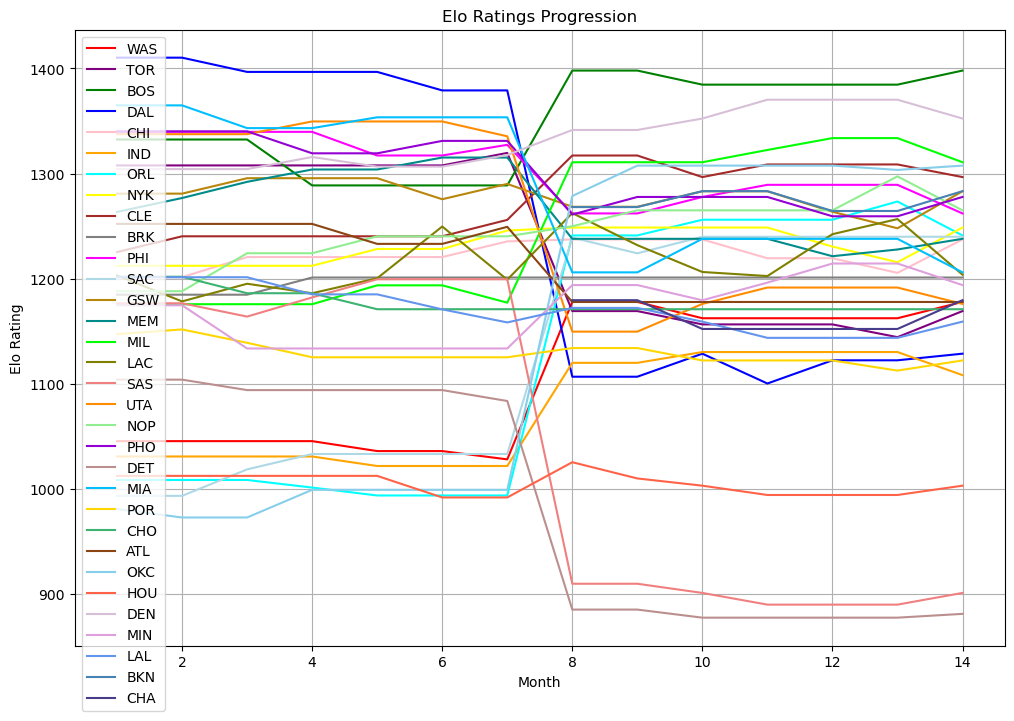

In [71]:
def plot_ratings(ratings_history):
    plt.figure(figsize=(12, 8))
    team_colors = {
    'WAS': 'red',
    'TOR': 'purple',
    'BOS': 'green',
    'DAL': 'blue',
    'CHI': 'pink',
    'IND': 'orange',
    'ORL': 'cyan',
    'NYK': 'yellow',
    'CLE': 'brown',
    'BRK': 'gray',
    'PHI': 'magenta',
    'SAC': 'lightblue',
    'GSW': 'darkgoldenrod',
    'MEM': 'darkcyan',
    'MIL': 'lime',
    'LAC': 'olive',
    'SAS': 'lightcoral',
    'UTA': 'darkorange',
    'NOP': 'lightgreen',
    'PHO': 'darkviolet',
    'DET': 'rosybrown',
    'MIA': 'deepskyblue',
    'POR': 'gold',
    'CHO': 'mediumseagreen',
    'ATL': 'saddlebrown',
    'OKC': 'skyblue',
    'HOU': 'tomato',
    'DEN': 'thistle',
    'MIN': 'plum',
    'LAL': 'cornflowerblue',
    'BKN': 'steelblue',
    'CHA': 'darkslateblue',
    }
    for team in players.keys():
        team_ratings = [ratings.get(team, None) for ratings in ratings_history.values()]
        plt.plot(range(1, len(team_ratings) + 1), team_ratings, label=team, color=team_colors.get(team, 'black'))

    plt.xlabel('Month')
    plt.ylabel('Elo Rating')
    plt.title('Elo Ratings Progression')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Plot Elo ratings over games
plot_ratings(ratings_history)

# Handle NaN values

In [18]:
# Because we need a player's previous 10 game gamescore average, we will exclude the first 10 nba games from our dataset.
nba_data = nba_data[(nba_data['Away_Tm_Gm_Num'] >= 10) & (nba_data['Home_Tm_Gm_Num'] >= 10)]

df = nba_data[['Series_Pt_Dif', 'Expected_Hm_Tm_Gm_Sc', 'Expected_Away_Tm_Gm_Sc', 'Away_Tm_Away_W/L_Prev_Gms', 
          'Home_Tm_Home_W/L_Prev_Gms', 'Away_Tm_Prev_Pt_Dif_Avg', 'Home_Tm_Prev_Pt_Dif_Avg',
              'Home_Tm_W/L_Prev_Gms', 'Away_Tm_W/L_Prev_Gms', 'Is_Home_Tm_Win']]

# If the W/L ratio is NaN, give it a value of 0.5 because 0.5 shouldn't have a large impact
df['Away_Tm_Away_W/L_Prev_Gms'] = df['Away_Tm_Away_W/L_Prev_Gms'].fillna(.5)
df['Home_Tm_Home_W/L_Prev_Gms'] = df['Home_Tm_Home_W/L_Prev_Gms'].fillna(.5)

df.head(5)

C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\3704122667.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Away_Tm_Away_W/L_Prev_Gms'] = df['Away_Tm_Away_W/L_Prev_Gms'].fillna(.5)
C:\Users\jahis\AppData\Local\Temp\ipykernel_21416\3704122667.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Home_Tm_Home_W/L_Prev_Gms'] = df['Home_Tm_Home_W/L_Prev_Gms'].fillna(.5)


,Series_Pt_Dif,Expected_Hm_Tm_Gm_Sc,Expected_Away_Tm_Gm_Sc,Away_Tm_Away_W/L_Prev_Gms,Home_Tm_Home_W/L_Prev_Gms,Away_Tm_Prev_Pt_Dif_Avg,Home_Tm_Prev_Pt_Dif_Avg,Home_Tm_W/L_Prev_Gms,Away_Tm_W/L_Prev_Gms,Is_Home_Tm_Win
9,0,82.756825,70.254603,0.500000,0.400000,-0.666667,5.111111,0.666667,0.555556,0
10,0,73.695000,81.455556,0.666667,0.333333,1.666667,4.500000,0.600000,0.666667,0
11,0,75.592262,91.753889,1.000000,0.000000,2.909091,-1.400000,0.400000,0.545455,1
12,0,88.767778,75.170000,0.800000,0.571429,1.333333,5.750000,0.666667,0.500000,0
13,0,89.431667,84.306667,0.625000,0.333333,-0.312500,0.200000,0.400000,0.437500,0


# Create the models
Use the best features for the Random Forest model and logistic regression model

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df[['Series_Pt_Dif', 'Expected_Hm_Tm_Gm_Sc', 'Expected_Away_Tm_Gm_Sc',
        'Away_Tm_W/L_Prev_Gms', 'Away_Tm_Prev_Pt_Dif_Avg', 'Home_Tm_Prev_Pt_Dif_Avg',
        'Home_Tm_W/L_Prev_Gms']]
y = df['Is_Home_Tm_Win']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize a Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Train the model on the resampled training set
lr_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression with SMOTE')
plt.show()

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (C:\Users\jahis\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py)

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

selected_features = ['Series_Pt_Dif', 'Expected_Hm_Tm_Gm_Sc', 'Expected_Away_Tm_Gm_Sc',
                     'Away_Tm_W/L_Prev_Gms', 'Away_Tm_Prev_Pt_Dif_Avg', 'Home_Tm_Prev_Pt_Dif_Avg',
                     'Home_Tm_W/L_Prev_Gms']

X = df[selected_features]
y = df['Is_Home_Tm_Win']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create the Random Forest Classifier with the best hyperparameters
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the resampled training set
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Oversampling with SMOTE')
plt.show()

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (C:\Users\jahis\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py)